# Reinforcement Learning

In this notebook we use value-based reinforcement learning algorithms on the [CliffWalking-v0](https://gymnasium.farama.org/environments/toy_text/cliff_walking/) task from [Gymnasium](https://gymnasium.farama.org/).

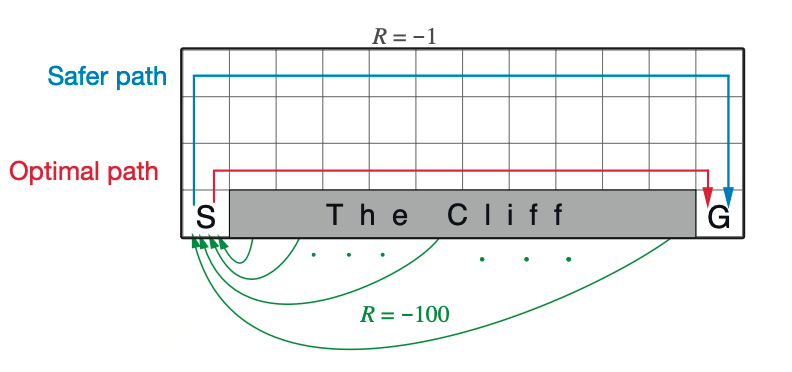

# Setup

In [ ]:
!sudo apt-get update --quiet
!pip install 'imageio==2.4.0' --quiet
!sudo apt-get install -y xvfb ffmpeg --quiet
!pip3 install gymnasium[classic_control] --quiet

Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:3 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Get:5 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:10 http://archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 Packages [2,176 kB]
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/multiverse amd64 Packages [61.3 kB]
Get:13 http://archive.ubuntu.com/ubuntu jammy-updates/ma

In [ ]:
import gymnasium as gym
import random
import base64
import imageio
import IPython
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
from scipy.signal import convolve as conv

In [ ]:
# @title helper and plotting functions

# disable warnings
import logging
logging.getLogger().setLevel(logging.ERROR)

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display
plt.ion()


def embed_mp4(filename):
    video = open(filename,'rb').read()
    b64 = base64.b64encode(video)
    tag = '''
    <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
    Your browser does not support the video tag.
    </video>'''.format(b64.decode())
    return IPython.display.HTML(tag)


def create_policy_eval_video(env, policy, filename, Q=None, num_episodes=1, fps=5, max_steps=48):
    filename = filename + ".mp4"
    with imageio.get_writer(filename, fps=fps) as video:
        for _ in range(num_episodes):
            state, info = env.reset()
            video.append_data(env.render())
            while max_steps >= 0:
                action = policy(state, Q)
                state, reward, terminated, truncated, info = env.step(action)
                max_steps -= 1
                video.append_data(env.render())
                if terminated or truncated:
                    break
            video.append_data(env.render())
        video.append_data(env.render())
    return embed_mp4(filename)


def plot_heatmap(env, value, ax=None, show=False):
    # Generate heatmap showing maximum value at each state
    if ax is None:
        fig, ax = plt.subplots()
    dim_x, dim_y = 12, 4
    action_max = value.argmax(axis=1)
    value_max = value.max(axis=1).reshape(dim_y, dim_x)
    act_dict = {0: 'U', 1: 'R', 2: 'D', 3: 'L'}
    act_dict = {0: '↑', 1: '→', 2: '↓', 3: '←'}
    labels = np.array([act_dict.get(action, '') for action in action_max])
    labels[37:-1], labels[-1] = ' ', 'G'
    labels = labels.reshape(dim_y, dim_x)
    im = sns.heatmap(value_max, cmap="inferno", annot=labels, annot_kws={'fontsize': 16}, fmt='s')
    if show:
        plt.show()
    return im


def plot_rewards(rewards, average_range=10, log=False, ax=None, show=False):
    # Generate plot showing total reward accumulated in each episode.
    n_episodes = len(rewards)
    if log:
        rewards = np.log10(-rewards)
    if ax is None:
        fig, ax = plt.subplots()
    smoothed_rewards = (conv(rewards, np.ones(average_range), mode='same')
                      / average_range)
    ax.plot(range(0, n_episodes, average_range), smoothed_rewards[0:n_episodes:average_range])
    ylab = 'Log of negative sum of rewards' if log else 'Total reward'
    ax.set(xlabel='Episodes', ylabel=ylab)
    if show:
      plt.show()


def plot_performance(env, value, reward_sums, log=False):
    fig, axes = plt.subplots(nrows=2, figsize=(12, 8))
    plot_rewards(reward_sums, ax=axes[0], log=log)
    plot_heatmap(env, value, ax=axes[1])
    plt.show(fig)

# Explore the Environment

In [ ]:
env = gym.make('CliffWalking-v0', render_mode='rgb_array')

print('Observations:', env.observation_space)
print('Actions:', env.action_space)

Observations: Discrete(48)
Actions: Discrete(4)


In [ ]:
def random_policy(*args):
    return np.random.randint(0, 4)

Visualizing the random policy.

In [ ]:
create_policy_eval_video(env, random_policy, 'random_policy', max_steps=200)

# Policies

In [ ]:
def greedy_policy(state, Q):
    """Greedy policy: selects the maximum value action.

    Args:
      state (integer): current state
      Q (ndarray): current value function of shape (n_states, n_actions)

    Returns:
      action (integer): the chosen action
    """
    return np.argmax(Q[state])

$\varepsilon$-greedy policy

In [ ]:
def epsilon_greedy(state, Q, epsilon):
    """Epsilon-greedy policy: selects the maximum value action with probabilty
        (1-epsilon) and selects randomly with epsilon probability.

    Args:
      state (integer): current state
      Q (ndarray): current value function of shape (n_states, n_actions)
      epsilon (float): probability of selecting an action randomly

    Returns:
      action (integer): the chosen action
    """
    max_a = np.argmax(Q[state])
    p = [epsilon / 4] * 4
    p_max_a = 1 - epsilon
    return np.random.choice([max_a] + [0, 1, 2, 3], p=[p_max_a] + p)

# Evaluate the Models

In [ ]:
def evaluate_policy(env, Q, num_episodes=10, max_steps=100):
    # G_t = 0
    reward_sums = np.zeros(num_episodes)
    for episode in range(num_episodes):
      state = env.reset()[0]
      current_steps = 0
      while max_steps > current_steps:
        current_steps += 1
        action = greedy_policy(state, Q)
        state, reward, terminated, truncated, _ = env.step(action)
        # G_t += reward
        reward_sums[episode] += reward
        # rewards.append(reward)
        if terminated or truncated:
          break


    # rewards = np.asarray(rewards)
    return reward_sums.mean(), reward_sums.std()

# Monte Carlo

## Learning

First we write the training loop for our MC algorithm. In this loop we generate a trajectory, list of tuples of (state, action, reward) for each step, for every episode, and then update the Q-values according to the learning rule (which is the MC algorithm). Actions are taken according to an epsilon-greedy policy where $\varepsilon = \max \left( \frac{1}{k}, \varepsilon_{end}\right)$ for the $k$-th episode.

In [ ]:
def mc_learn_env(env, learning_rule, n_episodes, gamma, final_eps=0.1):
    Q = np.zeros((env.observation_space.n, env.action_space.n))
    N = np.zeros((env.observation_space.n, env.action_space.n))

    # Store sum of rewards for different episodes in learning
    reward_sums = np.zeros(n_episodes)

    # Loop over episodes
    for k in tqdm(range(1, n_episodes + 1)):
        epsilon = max(1/k, final_eps)
        trajectory, first_visits = list(), dict()
        step_counter, done = 0, False
        state, info = env.reset()
        while not done:
            action = epsilon_greedy(state, Q, epsilon)
            next_state, reward, terminated, truncated, _ = env.step(action)
            trajectory.append((state, action, reward))

            if (state, action) not in first_visits.keys():
              first_visits[(state, action)] = step_counter
            state = next_state
            reward_sums[k-1] += reward
            step_counter += 1
            if terminated:
              done = True
        # Update Q and N
        Q, N = learning_rule(Q, N, trajectory, first_visits, step_counter, gamma)
    return Q, reward_sums

## First-visit MC Online Control

In [ ]:
def first_visit_MC_online_control(Q, N, trajectory, first_visits, T, gamma):
    """Q-learning: updates the value function and returns it.

    Args:
      Q (ndarray): current value function of shape (n_states, n_actions)
      N (ndarray): current number of visits of shape (n_states, n_actions)
      trajectory (list): (state, action, reward) tuples from episode
      first_visits (dict): first visit index of (state, action) pairs
      T (int): length of the current episode
      gamma (float): discount factor

    Returns:
      Q (ndarray): the updated value function of shape (n_states, n_actions)
      N (ndarray): the updated number of visits of shape (n_states, n_actions)
    """
    G = 0
    for t in range(T):
        state, action, _ = trajectory[t]
        if first_visits[(state, action)] == t:
            G = sum([sar[2] * pow(gamma, i) for i, sar in enumerate(reversed(trajectory[t:]))])
            N[state][action] += 1
            Q[state][action] += (G - Q[state][action]) / N[state][action]

    return Q, N

Now we trian after setting the hyperparameters

100%|██████████| 5000/5000 [00:07<00:00, 626.28it/s]



Monte Carlo mean_reward = -15.00 +/- 0.0000



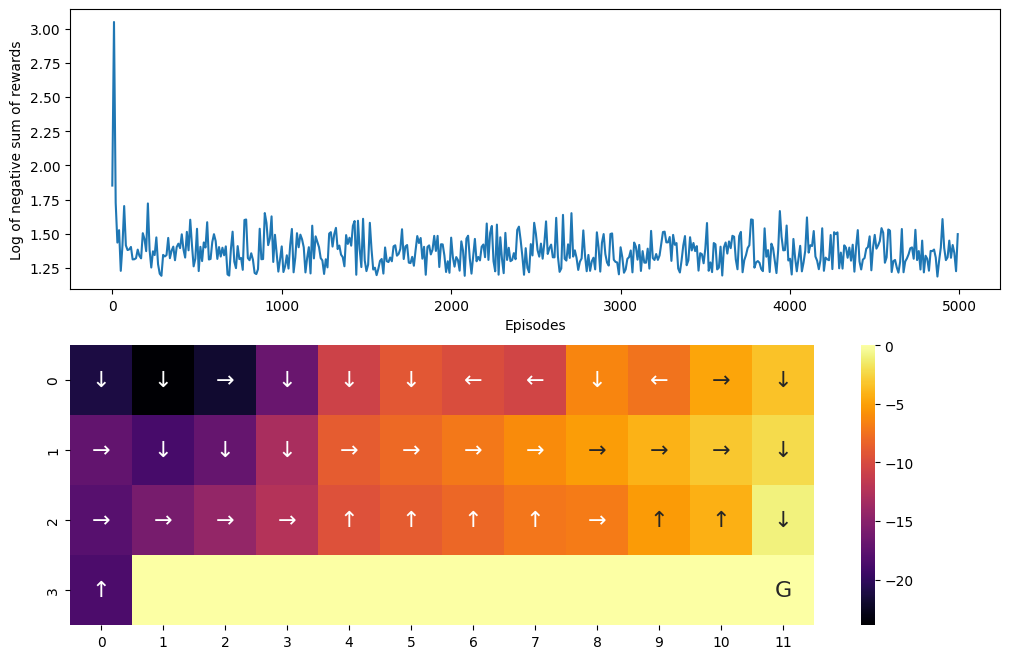

In [ ]:
# Set for reproducibility, comment out / change seed value for different results
np.random.seed(42)

gamma = 0.9552

n_episodes = 5000

# Initialize environment
env = gym.make('CliffWalking-v0')

# Solve Cliff Walking using MC Control
results = mc_learn_env(env, first_visit_MC_online_control, n_episodes, gamma)
value_mc, reward_sums_mc = results

# Evaluate MC Control method
mean_reward, std_reward = evaluate_policy(env, value_mc)
print(f"\nMonte Carlo mean_reward = {mean_reward:.2f} +/- {std_reward:.4f}\n")

# Plot results
plot_performance(env, value_mc, reward_sums_mc, log=True)

# Turn on render mode
env = gym.make('CliffWalking-v0', render_mode='rgb_array')
create_policy_eval_video(env, greedy_policy, 'Monte Carlo', value_mc)

# Temporal Difference

As we've seen, MC methods may have some shortcomings and in this section we wish to use TD methods to overcome some of the challenges we've encountered in the previous section. Since it takes a long time for each episode to end, the learning process in MC is very slow. TD methods, in contrast to MC methods which can only learn after one full episode, can learn from every step within an episode.

We take a look at two different TD algorithms:

*   Q-learning
*   SARSA

Additionally we use the idea of eligibility traces to check the performance of other variants of these algorithms. Eligibility traces are a mechanism for attributing credit or blame for rewards received to actions taken in the past. As a result we also take a look at:

*   Q(λ)
*   SARSA(λ)







## Learning

Similar to the MC section, we first define a learning function. However in TD, unlike MC, we use the `learning_rule` after each step.

In [ ]:
def learn_environment(env, learning_rule, params, max_steps, n_episodes):
    # Initialize Q
    Q = np.zeros((env.observation_space.n, env.action_space.n))
    eligibility_traces = True if 'lambda' in params.keys() else False
    if eligibility_traces: # Initialize E
        E = np.zeros((env.observation_space.n, env.action_space.n))

    # Store sum of rewards for different episodes in learning
    reward_sums = np.zeros(n_episodes)
    # Loop over episodes
    for episode in tqdm(range(n_episodes)):
        state, info = env.reset()  # initialize state
        for _ in range(max_steps):
            action = epsilon_greedy(state, Q, params['epsilon'])
            next_state, reward, terminated, truncated, _ = env.step(action)
            if eligibility_traces: # Update Q-values and eligibility traces
                next_action = epsilon_greedy(next_state, Q, params['epsilon'])
                Q, E = learning_rule(state, action, reward, next_state, next_action, Q, E, params)
            else: # Update Q-values
                next_action = greedy_policy(next_state, Q)
                Q = learning_rule(state, action, reward, next_state, next_action, Q, params)
            state = next_state
            reward_sums[episode] += reward
            if terminated or truncated:
              break
    return Q, reward_sums

## Q-learning

### Q-learning

In [ ]:
def q_learning(state, action, reward, next_state, next_action, Q, params):
    """Q-learning: updates the value function and returns it.

    Args:
      state (int): the current state identifier
      action (int): the action taken
      reward (float): the reward received
      next_state (int): the transitioned to state identifier
      next_action (int): the next action we're going to take
      Q (ndarray): current value function of shape (n_states, n_actions)
      params (dict): a dictionary containing the default parameters

    Returns:
      Q (ndarray): the updated value function of shape (n_states, n_actions)
    """
    TD_error = reward + (params['gamma'] * Q[next_state][next_action]) - Q[state][action]
    Q[state][action] += params['alpha'] * TD_error
    return Q

100%|██████████| 500/500 [00:00<00:00, 678.76it/s]



Q-learning mean_reward = -13.00 +/- 0.0000



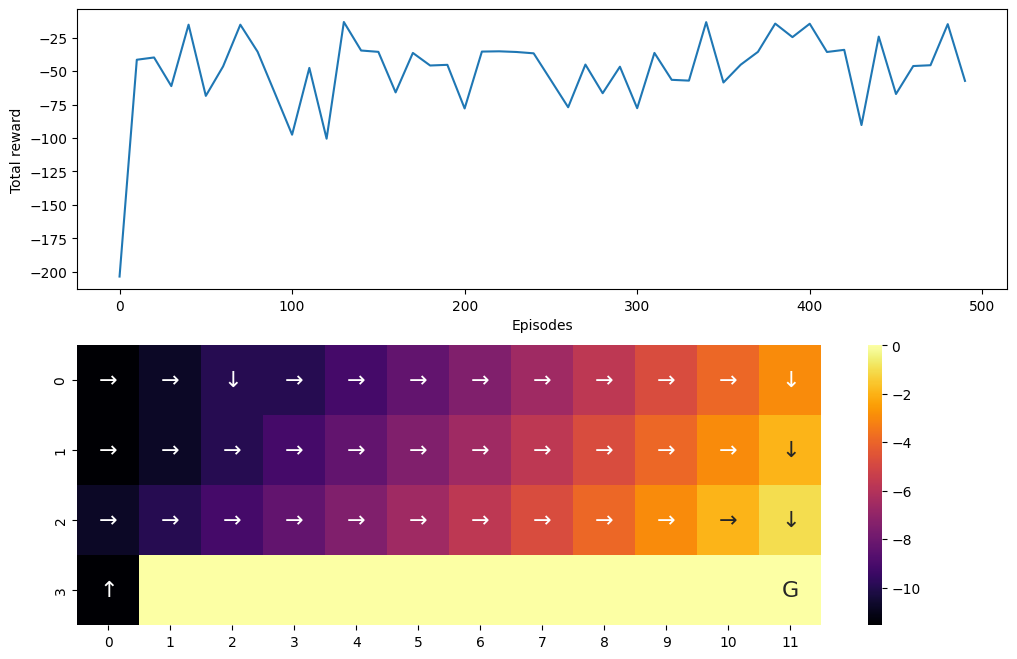

In [ ]:
# Set for reproducibility, comment out / change seed value for different results
np.random.seed(42)

params = {'epsilon': 0.1,      # exploration rate
          'alpha': 1,      # learning rate
          'gamma': 0.98          # discount factor
          }

n_episodes = 500
max_steps = 1000

# Initialize environment
env = gym.make('CliffWalking-v0')

# Solve Cliff Walking using Q-learning
results = learn_environment(env, q_learning, params, max_steps, n_episodes)
value_q_learning, reward_sums_q_learning = results

# Evaluate Q-learning
mean_reward, std_reward = evaluate_policy(env, value_q_learning)
print(f"\nQ-learning mean_reward = {mean_reward:.2f} +/- {std_reward:.4f}\n")

# Plot results
plot_performance(env, value_q_learning, reward_sums_q_learning)

# Turn on render mode
env = gym.make('CliffWalking-v0', render_mode='rgb_array')
create_policy_eval_video(env, greedy_policy, 'Q-learning', value_q_learning)

### Q(λ)

In [ ]:
def q_lambda(state, action, reward, next_state, next_action, Q, E, params):
    """Q-Learning with Eligibility Traces: updates the value function using Q-learning with eligibility traces.

    Args:
      state (int): the current state identifier
      action (int): the action taken
      reward (float): the reward received
      next_state (int): the transitioned to state identifier
      next_action (int): the next action we're going to take
      Q (ndarray): current value function of shape (n_states, n_actions)
      E (ndarray): eligibility traces of shape (n_states, n_actions)
      params (dict): a dictionary containing the hyperparameters

    Returns:
      Q (ndarray): the updated value function Q of shape (n_states, n_actions)
      E (ndarray): the updated eligibility traces E of shape (n_states, n_actions)
    """
    """
    # Already given (next_action)
    """
    TD_error = reward + (params['gamma'] * Q[next_state][next_action]) - Q[state][action]
    E = params['gamma'] * params['lambda'] * E
    E[state][action] += 1
    Q[state][action] += params['alpha'] * TD_error * E[state][action]
    return Q, E

100%|██████████| 500/500 [00:01<00:00, 456.79it/s]



Q(λ) mean_reward = -15.00 +/- 0.0000



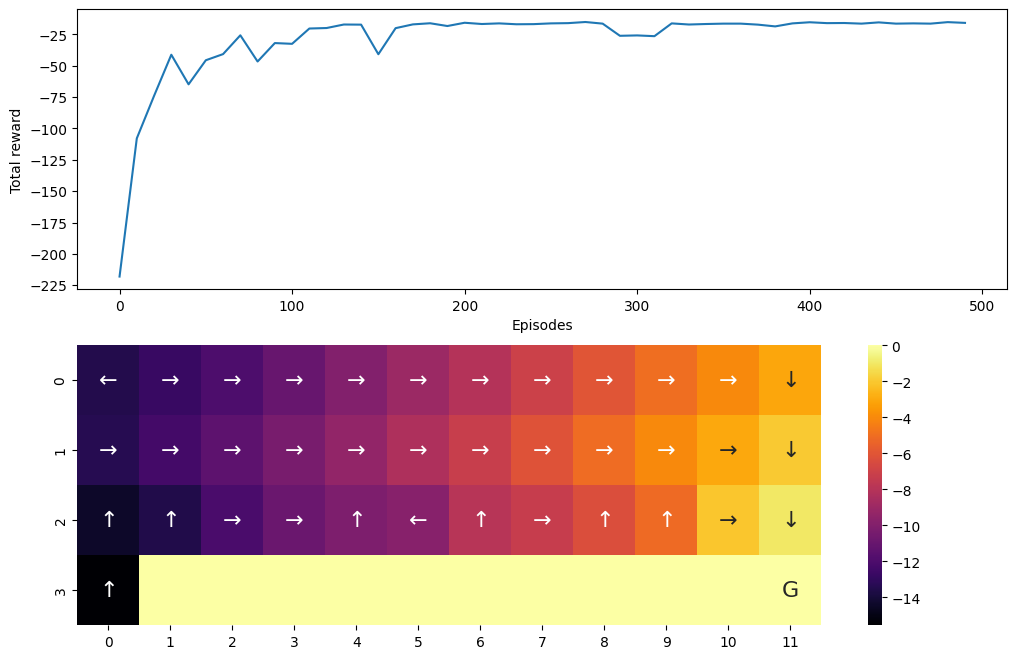

In [ ]:
# Set for reproducibility, comment out / change seed value for different results
np.random.seed(42)

params = {'epsilon':0.05,      # exploration rate
          'alpha':0.25,        # learning rate
          'gamma':1.0,        # discount factor
          'lambda':0.9        # trace parameter
          }

n_episodes = 500
max_steps = 2000

# Initialize environment
env = gym.make('CliffWalking-v0')

# Solve Cliff Walking using Q(λ)
results = learn_environment(env, q_lambda, params, max_steps, n_episodes)
value_q_lambda, reward_sums_q_lambda = results

# Evaluate Q(λ)
mean_reward, std_reward = evaluate_policy(env, value_q_lambda)
print(f"\nQ(λ) mean_reward = {mean_reward:.2f} +/- {std_reward:.4f}\n")

# Plot results
plot_performance(env, value_q_lambda, reward_sums_q_lambda)

# Turn on render mode
env = gym.make('CliffWalking-v0', render_mode='rgb_array')
create_policy_eval_video(env, greedy_policy, 'Q(λ)', value_q_lambda)

## SARSA

### SARSA

In [ ]:
def sarsa(state, action, reward, next_state, next_action, Q, params):
    """SARSA: updates the value function and returns it.

    Args:
      state (int): the current state identifier
      action (int): the action taken
      reward (float): the reward received
      next_state (int): the transitioned to state identifier
      next_action (int): the next action we're going to take
      Q (ndarray): current value function of shape (n_states, n_actions)
      params (dict): a dictionary containing the default parameters

    Returns:
      Q (ndarray): the updated value function of shape (n_states, n_actions)
    """
    TD_error = reward + (params['gamma'] * Q[next_state][next_action]) - Q[state][action]
    Q[state][action] += params['alpha'] * TD_error
    return Q

100%|██████████| 500/500 [00:00<00:00, 998.05it/s]



SARSA mean_reward = -13.00 +/- 0.0000



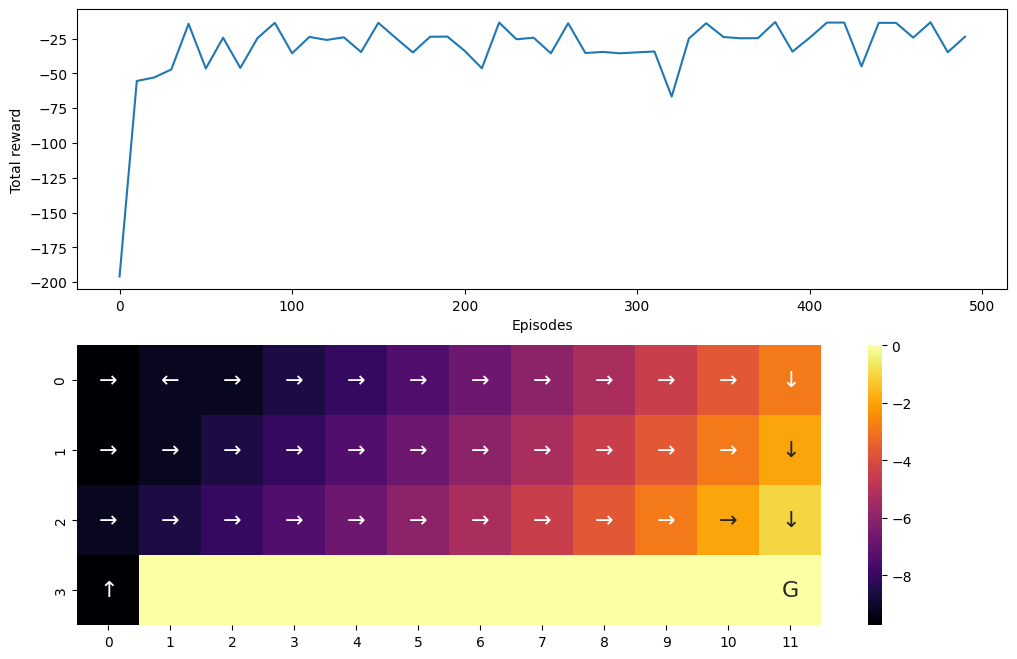

In [ ]:
# Set for reproducibility, comment out / change seed value for different results
np.random.seed(42)

params = {'epsilon': 0.05 ,      # exploration rate
          'alpha': 1.0 ,        # learning rate
          'gamma': 0.95          # discount factor
          }

n_episodes =  500
max_steps = 1000

# Initialize environment
env = gym.make('CliffWalking-v0')

# Solve Cliff Walking using SARSA
results = learn_environment(env, sarsa, params, max_steps, n_episodes)
value_sarsa, reward_sums_sarsa = results

# Evaluate Q-learning
mean_reward, std_reward = evaluate_policy(env, value_sarsa)
print(f"\nSARSA mean_reward = {mean_reward:.2f} +/- {std_reward:.4f}\n")

# Plot results
plot_performance(env, value_sarsa, reward_sums_sarsa)

# Turn on render mode
env = gym.make('CliffWalking-v0', render_mode='rgb_array')
create_policy_eval_video(env, greedy_policy, 'SARSA', value_sarsa)

### SARSA(λ)

In [ ]:
def sarsa_lambda(state, action, reward, next_state, next_action, Q, E, params):
    """SARSA(λ): updates the value function using SARSA(λ) algorithm.

    Args:
      state (int): the current state identifier
      action (int): the action taken
      reward (float): the reward received
      next_state (int): the transitioned to state identifier
      next_action (int): the next action we're going to take
      Q (ndarray): current value function of shape (n_states, n_actions)
      E (ndarray): eligibility traces of shape (n_states, n_actions)
      params (dict): a dictionary containing the hyperparameters

    Returns:
      Q (ndarray): the updated value function Q of shape (n_states, n_actions)
      E (ndarray): the updated eligibility traces E of shape (n_states, n_actions)
    """

    TD_error = reward + (params['gamma'] * Q[next_state][next_action]) - Q[state][action]
    E = (params['gamma'] * params['lambda'] * E)
    E[state][action] += 1
    Q[state][action] += params['alpha'] * TD_error * E[state][action]
    return Q, E

100%|██████████| 500/500 [00:01<00:00, 498.07it/s]



SARSA(λ) mean_reward = -15.00 +/- 0.0000



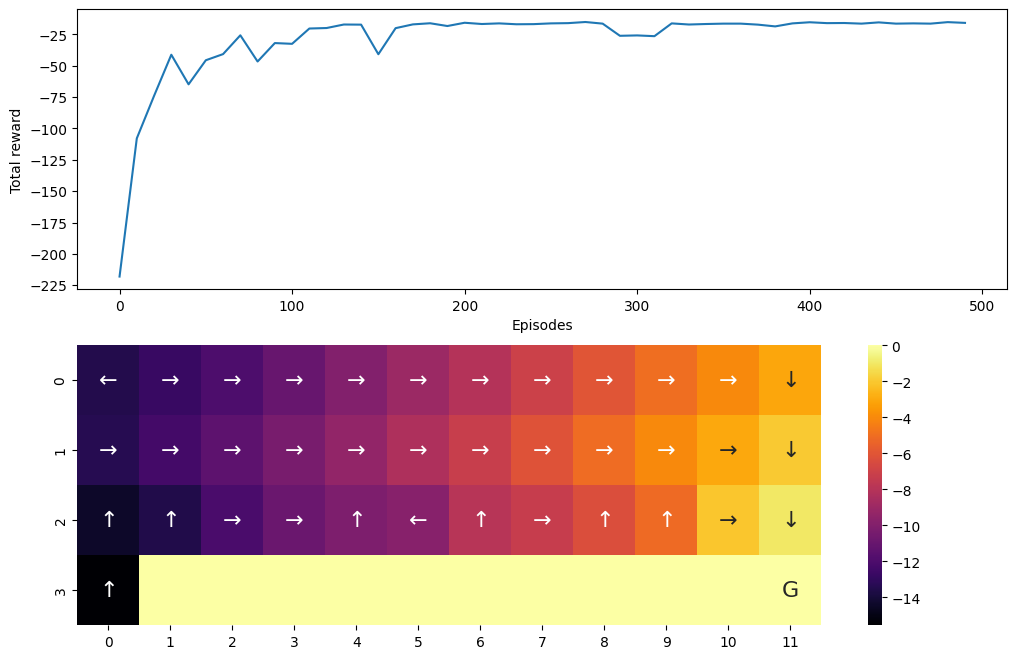

In [ ]:
# Set for reproducibility, comment out / change seed value for different results
np.random.seed(42)

params = {'epsilon': 0.05 ,      # exploration rate
          'alpha': 0.25 ,        # learning rate
          'gamma': 1.0 ,        # discount factor
          'lambda': 0.9         # trace parameter
          }

n_episodes = 500
max_steps = 1000

# Initialize environment
env = gym.make('CliffWalking-v0')

# Solve Cliff Walking using SARSA(λ)
results = learn_environment(env, sarsa_lambda, params, max_steps, n_episodes)
value_sarsa_lambda, reward_sums_sarsa_lambda = results

# Evaluate SARSA(λ)
mean_reward, std_reward = evaluate_policy(env, value_sarsa_lambda)
print(f"\nSARSA(λ) mean_reward = {mean_reward:.2f} +/- {std_reward:.4f}\n")

# Plot results
plot_performance(env, value_sarsa_lambda, reward_sums_sarsa_lambda)

# Turn on render mode
env = gym.make('CliffWalking-v0', render_mode='rgb_array')
create_policy_eval_video(env, greedy_policy, 'SARSA(λ)', value_sarsa_lambda)